In [1]:
import pandas as pd
import requests
from urllib.request import urlopen, urlretrieve
from bs4 import BeautifulSoup
import json
import openpyxl
import datetime
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


%matplotlib inline

In [2]:
plt.style.use('ggplot')  # Красивые графики
plt.rcParams['figure.figsize'] = (15, 5)  # Размер картинок

In [3]:
data = pd.read_excel('Выгрузка.xlsx')

In [4]:
def del_defis(x):
    if x == '-':
        return ''
    else:
        return x
    
for column in data.columns:
    if column.startswith('Ф_') or column.startswith('Р_'):
        data[column] = data[column].apply(del_defis)

In [5]:
def non_empty(lst, row):
    arr = []
    for key in lst:
        if any([i.isalnum() for i in str(row[key])]):
            temp_name = key[2:]
            if temp_name not in ('Город', 'Нас.пункт', 'Улица'):
                arr.append(temp_name + ' ' + str(row[key]))
            else:
                arr.append(str(row[key]))
    return ' '.join(arr)        



def get_adress(row):
    if row['Ф_Полный адрес'] == '' and row['Р_Город'] == '' and row['Р_Нас.пункт'] == '' and row['Р_Улица'] == '':
        return ''
    elif row['Р_Город'] == '' and row['Р_Нас.пункт'] == '' and row['Р_Улица'] == '':
        if 'новосибирск' in str(row['Ф_Полный адрес']).lower():
            return row['Ф_Полный адрес']
        else:
            return 'г.Новосибириск ' + str(row['Ф_Полный адрес'])
    else:
        return non_empty(['Р_Город', 'Р_Нас.пункт', 'Р_Улица', 'Р_Дом', 'Р_Корпус'], row)
    
    
data['Adress'] = data.apply(get_adress, axis=1)    
    

In [6]:
api_key = 'b996ed8b-dc1b-4dee-8687-bbb4b26dd313'

url = 'https://geocode-maps.yandex.ru/1.x?geocode='


def addr(b):
    a = b.replace(' ', '')
    a = str(a.encode('utf8'))
    i = a[2]
    a2 = ''.join(a.split(i))
    a3 = a2.replace('x', '%')
    resp = urlopen(url + a3.upper() + '&apikey=' + api_key + '&format=json')
    rows = resp.read().decode('utf8') # считываем содержимое
    lst = json.loads(rows)
    coords = lst['response']['GeoObjectCollection']['featureMember'][0]['GeoObject']['Point']['pos'].split()
    return [coords[1], coords[0]]




from decimal import Decimal

from yandex_geocoder import Client


client = Client(api_key)




In [7]:
def to_date(s):
    try:
        return pd.to_datetime(s, format='%Y-%m-%d %H:%M:%S').time()
    except:
        return datetime.time(0)



data['Время посещения'] = data['Дата и время посещения'].apply(to_date)

In [8]:
data = data.sort_values(by=['Номер карты', 'Дата приема', 'Время посещения']).reset_index(drop=True)

In [9]:
def first_visit(row):
    if row['Дата приема'] == row['Дата первого посещения']:
        min_time = data[(data['Номер карты'] == row['Номер карты']) & (data['Дата приема'] == row['Дата приема'])]['Время посещения'].min()
        if row['Время посещения'] == min_time:
            return True
    return False    

data['Первое обращение'] = data.apply(first_visit, axis=1)

In [10]:
data['Возраст'] = (data['Дата приема'] - data['Дата рождения']).apply(lambda x: int(x.days // 365.25))

#.apply(lambda x: int((datetime.datetime.today().date() - x.date()).days // 365.25))


In [11]:
def age_group(age):
    arr = [
        range(0, 1),
        range(1, 3),
        range(3, 7),
        range(7, 15),
        range(15, 18),
        range(18, 25),
        range(25, 35),
        range(35, 45),
        range(45, 55),
        range(55, 65),
        range(65, 75),
        range(75, 85),
        range(85, 95),
        range(95, 105),
        range(105, 115),
        range(115, 125),
        range(125, 135),
        range(135, 145),
        range(145, 1000)
        
    ]
    
    for i in arr:
        if age in i:
            temp_s = str(i).replace('range', '').replace('(', '').replace(')', '').split(', ')
            if temp_s[1] == '1000':
                return '145 лет и более'
            elif temp_s[1] == '1':
                return 'До 1 года'
            else:
                return f'{int(temp_s[0])}-{int(temp_s[1])-1} года'
    

In [12]:
data['Возрастная группа'] = data['Возраст'].apply(age_group)

In [13]:
data['МДВ'] = data['Возраст'].apply(lambda x: 'Ребенок' if x < 18 else 'Взрослый')

In [14]:
adresses = data[data['Adress'] != ''].drop_duplicates(subset=['Adress'])['Adress']

In [185]:
def coord_yandex(s):
    try:
        return list(map(float, client.coordinates(s)))[::-1]
    except:
        return '' 

In [186]:
dct = {}

for i in adresses:
    dct.setdefault(i, coord_yandex(i))
    time.sleep(0.1)

In [190]:
for i in [key for key,value in dct.items() if value=='']:
    dct[i] = coord_yandex(i)
    time.sleep(0.1)

In [191]:
[key for key,value in dct.items() if value=='']

['г.Новосибириск В/г 17, общ.1066/1 комн.15',
 'г.Новосибириск тст Золотая Горка, Аллея Ж дом 1',
 'г.Новосибириск НСО Северная, ул. Гагарина 2а - 4',
 'г.Новосибириск коттеджн.пос. березки ул 4-я восточная - 4',
 'г.Новосибириск nan',
 'г.Новосибириск Озерный ТСЖ Солнечный ул. Тихая гавань 173Б',
 'г.Новосибириск Краснообск ул. Гефест 1 дом 75',
 'г Бердск ул Микрорайон Дом 6',
 'г.Новосибириск п Мичуринский ДНП "Планета" ул. Утреняя 8',
 'г.Новосибириск снт Славянка, пер. 19-ый Генералиссимуса Сталина И.В., д5/1',
 'с Новокаменка тер Удачный ДНТ Дом 33',
 'рп Коченево ул Полевой ж/м Линия 3-я Дом 19',
 'г.Новосибириск п. Озерный мкр Солнечный ул.Римская 245']

In [194]:
coords_adresses = pd.DataFrame({'Адрес' : [i for i in dct.keys()], 'Координаты' : [i for i in dct.values()]})


In [196]:
coords_adresses = coords_adresses[coords_adresses['Координаты'] != '']

In [199]:
coords_adresses.to_excel('coords_adresses.xlsx', index=False)

In [201]:
data.columns

Index(['Номер карты', 'Пациент', 'Пол', 'Дата рождения', 'Категория клиента',
       'Год', 'Месяц', 'Дата приема', 'Дата и время посещения',
       'Дата первого посещения', 'Наименование услуги', 'Sum([Количество])',
       'Sum([Всего начислено])', 'Ф_Полный адрес', 'Р_Город', 'Р_Нас.пункт',
       'Р_Улица', 'Р_Дом', 'Р_Корпус', 'Adress', 'Время посещения',
       'Первое обращение', 'Возраст', 'Возрастная группа', 'МДВ'],
      dtype='object')

In [26]:
data_first = data.groupby(by=['Возрастная группа', 'Пол'], as_index=False).agg({'Номер карты': 'nunique',
                                             'Sum([Количество])' : 'sum',
                                             'Sum([Всего начислено])' : 'sum'})

In [27]:
data_first['sort'] = data_first['Возрастная группа'].apply(lambda x: int(''.join([i for i in x if i.isdigit()])))

In [28]:
data_first

,Возрастная группа,Пол,Номер карты,Sum([Количество]),Sum([Всего начислено]),sort
0,1-2 года,Женский,635,2923,2286555.88,12
1,1-2 года,Мужской,770,3829,2416113.03,12
2,15-17 года,Женский,190,942,643458.00,1517
3,15-17 года,Мужской,154,502,380702.92,1517
4,18-24 года,Женский,1023,6712,4359704.96,1824
5,18-24 года,Мужской,441,1995,1189254.00,1824
6,25-34 года,Женский,2164,17665,11931968.17,2534
7,25-34 года,Мужской,970,4696,3041038.63,2534
8,3-6 года,Женский,891,4509,3439627.61,36
9,3-6 года,Мужской,996,4583,3254310.17,36


In [29]:
data_first = data_first.sort_values('sort').drop('sort', axis=1).reset_index(drop=True).rename(columns={'Номер карты' : 'Кол-во клиентов',
                                                                                                       'Sum([Количество])' : 'Кол-во услуг',
                                                                                                       'Sum([Всего начислено])' : 'Выработка'})

In [30]:
data_first.to_excel('data_first.xlsx', index=False)

In [31]:
data_first['Возр. гр.'] = data_first['Возрастная группа'].apply(lambda x: int(''.join([i for i in x if i.isdigit()])))
data_first

,Возрастная группа,Пол,Кол-во клиентов,Кол-во услуг,Выработка,Возр. гр.
0,До 1 года,Мужской,870,3112,2319756.32,1
1,До 1 года,Женский,713,2614,2072721.40,1
2,1-2 года,Женский,635,2923,2286555.88,12
3,1-2 года,Мужской,770,3829,2416113.03,12
4,3-6 года,Женский,891,4509,3439627.61,36
5,3-6 года,Мужской,996,4583,3254310.17,36
6,7-14 года,Мужской,683,2551,1804179.10,714
7,7-14 года,Женский,675,2577,1869287.84,714
8,15-17 года,Мужской,154,502,380702.92,1517
9,15-17 года,Женский,190,942,643458.00,1517


In [294]:
sex = data_first.pivot_table('Кол-во клиентов', index='Пол', columns='Возр. гр.').T

In [295]:
order = data_first['Возрастная группа'].drop_duplicates()
order

0       До 1 года
2        1-2 года
4        3-6 года
6       7-14 года
8      15-17 года
10     18-24 года
12     25-34 года
14     35-44 года
16     45-54 года
18     55-64 года
20     65-74 года
22     75-84 года
24     85-94 года
26    95-104 года
Name: Возрастная группа, dtype: object

[Text(0, 0, 'До 1 года'),
 Text(0, 0, '1-2 года'),
 Text(0, 0, '3-6 года'),
 Text(0, 0, '7-14 года'),
 Text(0, 0, '15-17 года'),
 Text(0, 0, '18-24 года'),
 Text(0, 0, '25-34 года'),
 Text(0, 0, '35-44 года'),
 Text(0, 0, '45-54 года'),
 Text(0, 0, '55-64 года'),
 Text(0, 0, '65-74 года'),
 Text(0, 0, '75-84 года'),
 Text(0, 0, '85-94 года'),
 Text(0, 0, '95-104 года')]

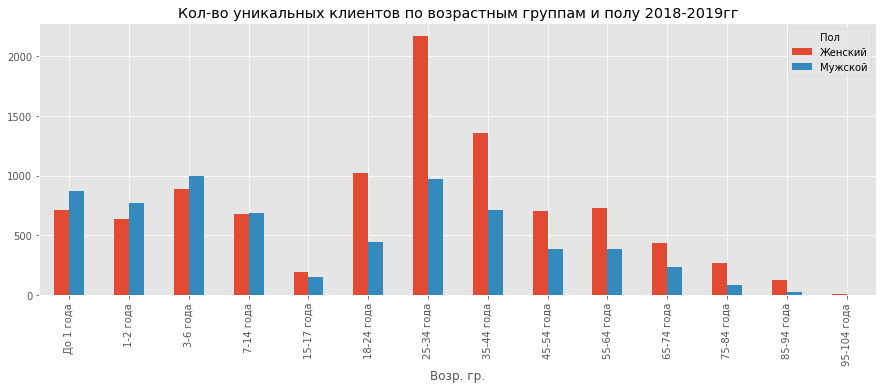

In [296]:
sex.plot(kind='bar', title = 'Кол-во уникальных клиентов по возрастным группам и полу 2018-2019гг')
ax = plt.gca()
# ax.set_xticks(range(14))
ax.set_xticklabels(order)

[Text(0, 0, 'До 1 года'),
 Text(0, 0, '1-2 года'),
 Text(0, 0, '3-6 года'),
 Text(0, 0, '7-14 года'),
 Text(0, 0, '15-17 года'),
 Text(0, 0, '18-24 года'),
 Text(0, 0, '25-34 года'),
 Text(0, 0, '35-44 года'),
 Text(0, 0, '45-54 года'),
 Text(0, 0, '55-64 года'),
 Text(0, 0, '65-74 года'),
 Text(0, 0, '75-84 года'),
 Text(0, 0, '85-94 года'),
 Text(0, 0, '95-104 года')]

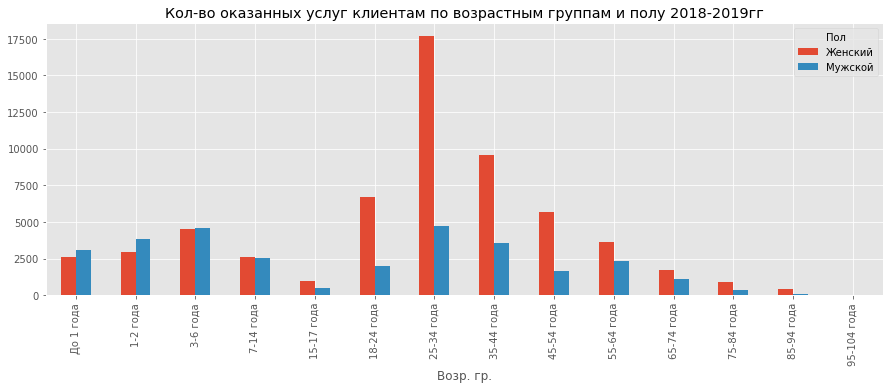

In [297]:
services = data_first.pivot_table('Кол-во услуг', index='Пол', columns='Возр. гр.').T
services.plot(kind='bar', title = 'Кол-во оказанных услуг клиентам по возрастным группам и полу 2018-2019гг')
ax = plt.gca()

ax.set_xticklabels(order)

[Text(0, 0, 'До 1 года'),
 Text(0, 0, '1-2 года'),
 Text(0, 0, '3-6 года'),
 Text(0, 0, '7-14 года'),
 Text(0, 0, '15-17 года'),
 Text(0, 0, '18-24 года'),
 Text(0, 0, '25-34 года'),
 Text(0, 0, '35-44 года'),
 Text(0, 0, '45-54 года'),
 Text(0, 0, '55-64 года'),
 Text(0, 0, '65-74 года'),
 Text(0, 0, '75-84 года'),
 Text(0, 0, '85-94 года'),
 Text(0, 0, '95-104 года')]

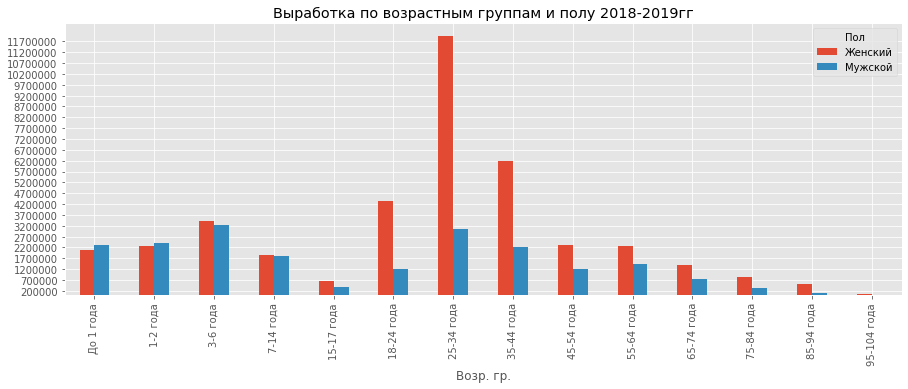

In [298]:
production = data_first.pivot_table('Выработка', index='Пол', columns='Возр. гр.').T
production.plot(kind='bar', title = 'Выработка по возрастным группам и полу 2018-2019гг', )
custom_ticks = range(200000, 12000000, 500000)
ax = plt.gca()
ax.set_yticks(custom_ticks)
ax.set_yticklabels(custom_ticks)
ax.set_xticklabels(order)


In [257]:
data_first[['Кол-во клиентов', 'Кол-во услуг', 'Выработка']].corr()

,Кол-во клиентов,Кол-во услуг,Выработка
Кол-во клиентов,1.000000,0.949569,0.955520
Кол-во услуг,0.949569,1.000000,0.990439
Выработка,0.955520,0.990439,1.000000


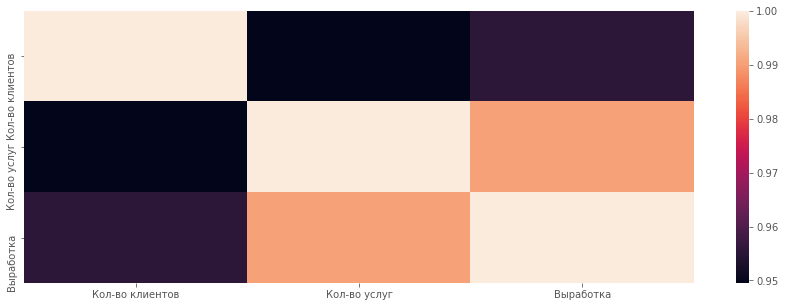

In [263]:
sns.heatmap(data_first.corr())

In [15]:
import statsmodels.stats.api as sms

sms.DescrStatsW(data_first['Выработка']).tconfint_mean()

NameError: name 'data_first' is not defined

In [16]:
data_second_first_visit = data[data['Первое обращение'] == True]

In [17]:
data_second_first_visit = data_second_first_visit.drop_duplicates(subset=['Номер карты']).reset_index(drop=True)

In [18]:
data_second_first_visit.columns

Index(['Номер карты', 'Пациент', 'Пол', 'Дата рождения', 'Категория клиента',
       'Год', 'Месяц', 'Дата приема', 'Дата и время посещения',
       'Дата первого посещения', 'Наименование услуги', 'Sum([Количество])',
       'Sum([Всего начислено])', 'Ф_Полный адрес', 'Р_Город', 'Р_Нас.пункт',
       'Р_Улица', 'Р_Дом', 'Р_Корпус', 'Adress', 'Время посещения',
       'Первое обращение', 'Возраст', 'Возрастная группа', 'МДВ'],
      dtype='object')

In [19]:

group_first_vizit = data_second_first_visit.groupby(['Наименование услуги'], as_index=False).agg({'Sum([Количество])': 'sum', 'Sum([Всего начислено])' : 'sum' })



In [20]:
group_first_vizit['% от суммы по кол-ву услуг'] = group_first_vizit['Sum([Количество])'].apply(lambda x: x / group_first_vizit['Sum([Количество])'].sum())

group_first_vizit['% от суммы по выработке'] = group_first_vizit['Sum([Всего начислено])'].apply(lambda x: x / group_first_vizit['Sum([Всего начислено])'].sum())

In [21]:
group_first_vizit = group_first_vizit.sort_values(by='Sum([Всего начислено])', ascending=False).reset_index(drop=True)

In [22]:
group_first_vizit.corr()

,Sum([Количество]),Sum([Всего начислено]),% от суммы по кол-ву услуг,% от суммы по выработке
Sum([Количество]),1.00000,0.92632,1.00000,0.92632
Sum([Всего начислено]),0.92632,1.00000,0.92632,1.00000
% от суммы по кол-ву услуг,1.00000,0.92632,1.00000,0.92632
% от суммы по выработке,0.92632,1.00000,0.92632,1.00000


In [23]:
group_first_vizit.iloc[21:, :].to_excel('Первые услугиаываываыва.xlsx')

In [24]:
group_first_vizit

,Наименование услуги,Sum([Количество]),Sum([Всего начислено]),% от суммы по кол-ву услуг,% от суммы по выработке
0,Консультация врача - дерматолога первичная в ...,1198,1497566.0,0.091681,0.104245
1,Консультация врача - отоларинголога первичная ...,1007,1295186.0,0.077064,0.090157
2,Консультация врача - педиатра первичная в амбу...,575,646752.0,0.044004,0.045020
3,Консультация врача - терапевта первичная в амб...,446,566254.0,0.034132,0.039417
4,"Консультация врача - кардиолога, зав.отд., вед...",272,485928.0,0.020816,0.033825
...,...,...,...,...,...
379,- Билирубин непрямой,1,90.0,0.000077,0.000006
380,- Железо,1,90.0,0.000077,0.000006
381,- Индекс атерогенности (при назначении холес...,1,90.0,0.000077,0.000006
382,- Протромбиновый индекс,1,70.0,0.000077,0.000005


In [25]:
group_first_vizit.quantile(0.5)

Sum([Количество])                3.000000
Sum([Всего начислено])        2400.000000
% от суммы по кол-ву услуг       0.000230
% от суммы по выработке          0.000167
Name: 0.5, dtype: float64

In [ ]:
#data.to_excel('temp.xlsx', index=False)

In [33]:
data_first['Средняя цена услуги'] = data_first['Выработка'] / data_first['Кол-во услуг']

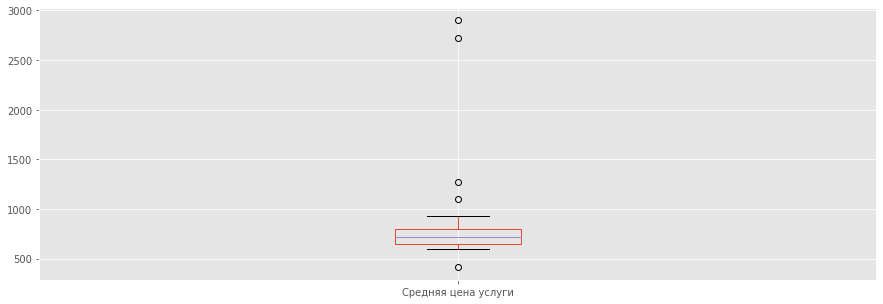

In [35]:
data_first['Средняя цена услуги'].plot(kind='box')

In [36]:
sms.DescrStatsW(data_first['Средняя цена услуги']).tconfint_mean()

(667.7071230382057, 1107.653131494413)

In [40]:
data_second_first_visit.head()

,Номер карты,Пациент,Пол,Дата рождения,Категория клиента,Год,Месяц,Дата приема,Дата и время посещения,Дата первого посещения,...,Р_Нас.пункт,Р_Улица,Р_Дом,Р_Корпус,Adress,Время посещения,Первое обращение,Возраст,Возрастная группа,МДВ
0,540000696,Белозер Ирина Владимировна,Женский,1968-10-08,НАЛ,2018,авг.,2018-08-15,2018-08-15 16:57:32,2018-08-15,...,,ул Адриена Лежена,,,г Новосибирск ул Адриена Лежена,16:57:32,True,49,45-54 года,Взрослый
1,540000832,Бородавкин Алексей Федорович,Мужской,1980-03-29,НАЛ,2018,сент.,2018-09-27,2018-09-27 18:00:07,2018-09-27,...,,,,,,18:00:07,True,38,35-44 года,Взрослый
2,540001483,Горбулина Валентина Васильевна,Женский,1954-07-01,НАЛ,2018,мар.,2018-03-01,-,2018-03-01,...,,ул Выборная,129,,г Новосибирск ул Выборная Дом 129,00:00:00,True,63,55-64 года,Взрослый
3,540001714,Довженко Валентина Николаевна,Женский,1955-09-03,НАЛ,2018,окт.,2018-10-30,2018-10-30 11:20:25,2018-10-30,...,,,,,,11:20:25,True,63,55-64 года,Взрослый
4,540002093,Иванова Екатерина Андреевна,Женский,1987-02-24,НАЛ,2018,мая,2018-05-10,2018-05-10 09:25:05,2018-05-10,...,,,,,,09:25:05,True,31,25-34 года,Взрослый


In [39]:
data_second_first_visit.columns

Index(['Номер карты', 'Пациент', 'Пол', 'Дата рождения', 'Категория клиента',
       'Год', 'Месяц', 'Дата приема', 'Дата и время посещения',
       'Дата первого посещения', 'Наименование услуги', 'Sum([Количество])',
       'Sum([Всего начислено])', 'Ф_Полный адрес', 'Р_Город', 'Р_Нас.пункт',
       'Р_Улица', 'Р_Дом', 'Р_Корпус', 'Adress', 'Время посещения',
       'Первое обращение', 'Возраст', 'Возрастная группа', 'МДВ'],
      dtype='object')

In [82]:
group_service_data_second_first_visit = data_second_first_visit.groupby(by=['Возрастная группа', 'Пол', 'Наименование услуги'], as_index=False).agg({
    'Номер карты' : 'nunique',
    'Sum([Количество])' : 'sum',
    'Sum([Всего начислено])' : 'sum'
})

In [83]:
group_service_data_second_first_visit['Возр. гр.'] = group_service_data_second_first_visit['Возрастная группа'].apply(lambda x: int(''.join([i for i in x if i.isdigit()])))

In [84]:
group_service_data_second_first_visit = group_service_data_second_first_visit.sort_values(['Возр. гр.', 'Пол', 'Sum([Всего начислено])'], ascending=[True, True, False])

In [85]:
group_service_data_second_first_visit = group_service_data_second_first_visit.reset_index(drop=True)

In [86]:
group_service_data_second_first_visit.groupby(by=['Возрастная группа', 'Пол']).head(5).to_excel('Первые 5 услуг в группах.xlsx')

In [101]:
category = data.groupby(by=['Категория клиента'], as_index=False).agg({'Номер карты': 'nunique',
                                             'Sum([Количество])' : 'sum',
                                             'Sum([Всего начислено])' : 'sum'})

In [102]:
category.to_excel('category.xlsx', index=False)

In [103]:
category = category.rename(columns={'Номер карты' : 'Кол-во клиентов',
                                   'Sum([Количество])' : 'Кол-во услуг',
                                   'Sum([Всего начислено])' : 'Выработка'})

[Text(0, 0, 'АБ МЦ'),
 Text(0, 0, 'КК'),
 Text(0, 0, 'НАЛ'),
 Text(0, 0, 'Нет в справочнике'),
 Text(0, 0, 'СК')]

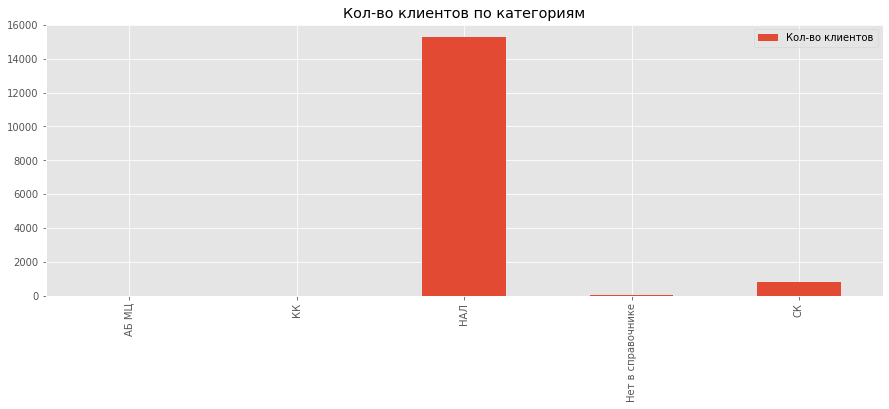

In [107]:
category[['Категория клиента', 'Кол-во клиентов']].plot(kind='bar', title='Кол-во клиентов по категориям')

ax = plt.gca()
ax.set_xticklabels(category['Категория клиента'])


[Text(0, 0, 'АБ МЦ'),
 Text(0, 0, 'КК'),
 Text(0, 0, 'НАЛ'),
 Text(0, 0, 'Нет в справочнике'),
 Text(0, 0, 'СК')]

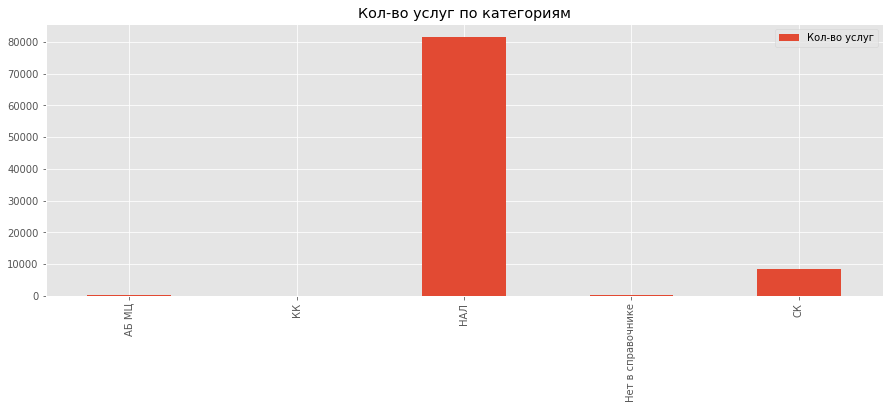

In [108]:
category[['Категория клиента', 'Кол-во услуг']].plot(kind='bar', title='Кол-во услуг по категориям')

ax = plt.gca()
ax.set_xticklabels(category['Категория клиента'])

[Text(0, 0, 'АБ МЦ'),
 Text(0, 0, 'КК'),
 Text(0, 0, 'НАЛ'),
 Text(0, 0, 'Нет в справочнике'),
 Text(0, 0, 'СК')]

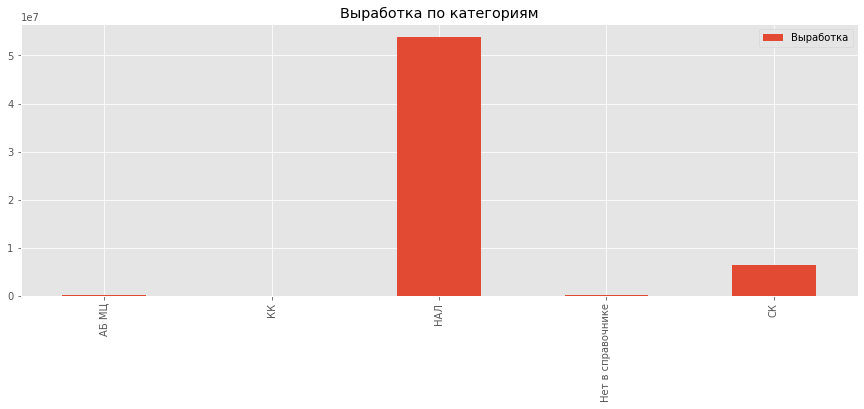

In [111]:
category[['Категория клиента', 'Выработка']].plot(kind='bar', title='Выработка по категориям')

ax = plt.gca()
ax.set_xticklabels(category['Категория клиента'])



In [112]:
category.corr()

,Кол-во клиентов,Кол-во услуг,Выработка
Кол-во клиентов,1.000000,0.998697,0.997693
Кол-во услуг,0.998697,1.000000,0.999857
Выработка,0.997693,0.999857,1.000000


In [ ]:
data